# Heart Failure Prediction Dataset
Data Sources:

1.- Primary Data:   https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data

2.- Observations:
  Data Quality Ensuring accuracy reliability and validity.

> Add blockquote



# Data Collection

In [38]:
# Installations
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm

# imports
import pandas as pd
import kagglehub
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier
)
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [39]:
#store data into drive in an specific folder
drive.mount('/content/drive')
filepath = "/content/drive/MyDrive/DataManagement2024/HeartFailureData/heart.csv"
raw_heart_df = pd.read_csv(filepath)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
raw_heart_df.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


In [41]:
raw_heart_df.tail(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


In [42]:
raw_heart_df.shape

(918, 12)

In [43]:
raw_heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Attribute Information

Categorical:
* Sex: {'F', 'M'} sex of the patient [M: Male, F: Female]

* Chest Pain Type (disconfort): {'ATA', 'ASY', 'TA', 'NAP'}  chest pain type
[TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

* Fasting BS: {0, 1} fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

* RestingECG: {'Normal', 'ST', 'LVH'}  resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

* Exercises Angina: {'N', 'Y'} exercise-induced angina [Y: Yes, N: No]

* ST_Slope: {'Up', 'Flat', 'Down'}  the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

* HeartDisease: {0, 1} output class [1: heart disease, 0: Normal]

Numeric:
* Age: age of the patient [years]
* RestingBP (measurement): resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* Oldpeak: ST [Numeric value measured in depression]


# Data Cleaning and preparation

In [44]:
numerical_columns = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
categorical_columns = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope','HeartDisease']

## Duplicate Data

In [45]:
raw_heart_df.duplicated().sum()

0

##  Missing Values

### Missing Values: Numerical Features

In [46]:
# Look for negatives in numerical data
negative_values = (raw_heart_df[numerical_columns] < 0).any()
print(negative_values)

Age            False
RestingBP      False
Cholesterol    False
MaxHR          False
Oldpeak         True
dtype: bool


In [47]:
print(raw_heart_df['Oldpeak'].min(), raw_heart_df['Oldpeak'].max())

-2.6 6.2


### Missing Values: Categorical Features

In [48]:
#categorical variables
print('Sex:',set(raw_heart_df['Sex']))
print('ChestPainType:',set(raw_heart_df['ChestPainType']))
print('FastingBS:',set(raw_heart_df['FastingBS']))
print('RestingECG:',set(raw_heart_df['RestingECG']))
print('ExerciseAngina',set(raw_heart_df['ExerciseAngina']))
print('ST_Slope',set(raw_heart_df['ST_Slope']))
#target
print('HeartDisease',set(raw_heart_df['HeartDisease']))

Sex: {'F', 'M'}
ChestPainType: {'ATA', 'TA', 'NAP', 'ASY'}
FastingBS: {0, 1}
RestingECG: {'Normal', 'LVH', 'ST'}
ExerciseAngina {'N', 'Y'}
ST_Slope {'Flat', 'Down', 'Up'}
HeartDisease {0, 1}


Notes:
  
  Require Potential Hot encoding Sex,ExerciseAngina
  
  Label encoding: ChestPainType, RestingECG, ST_Slope

  No missing values in categorical data.

## Outliers

## Detecting Outliers

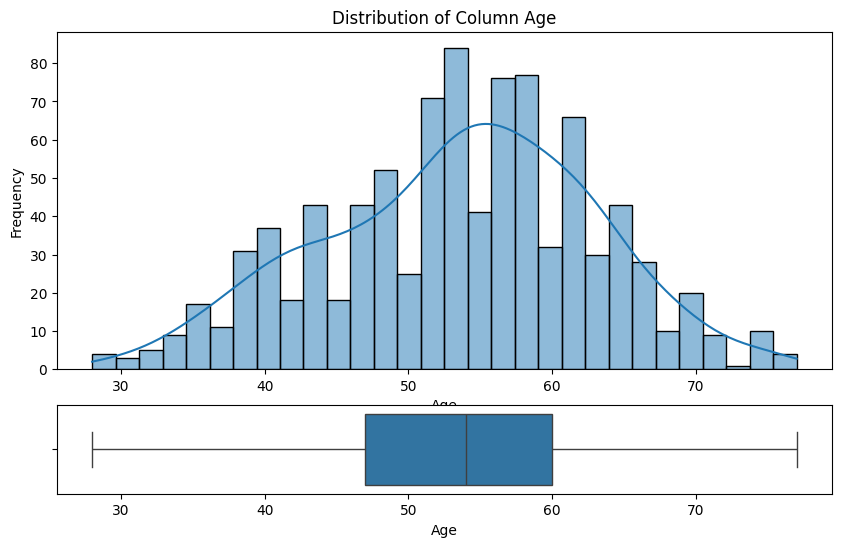

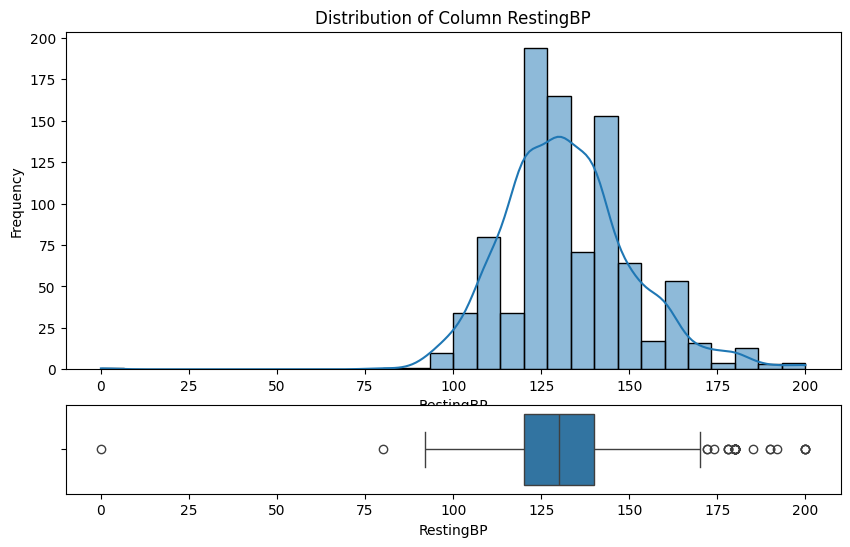

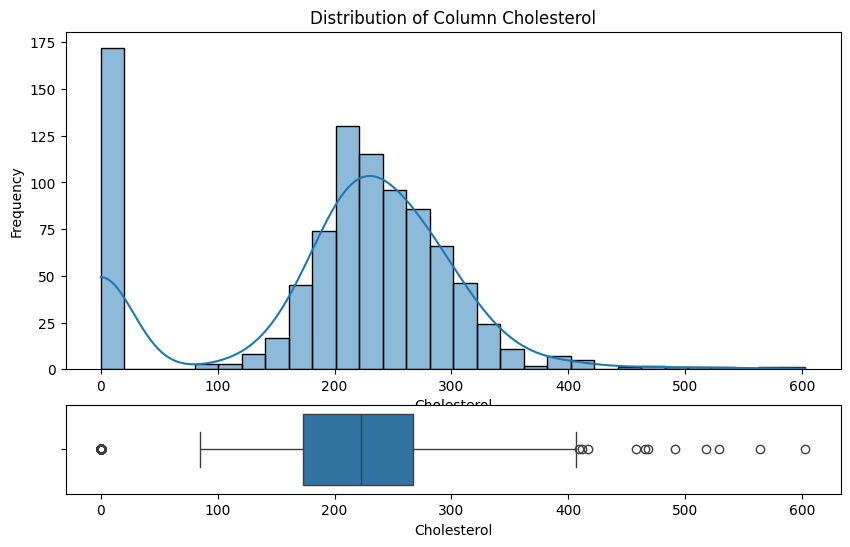

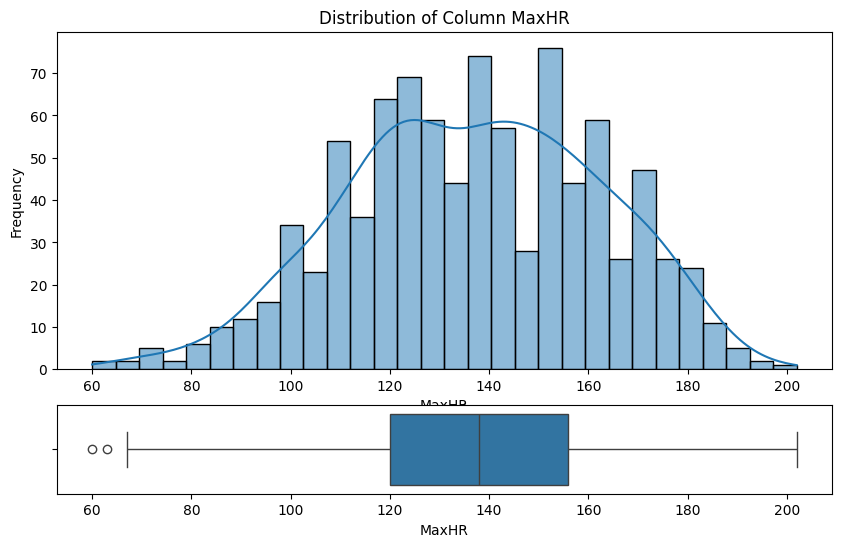

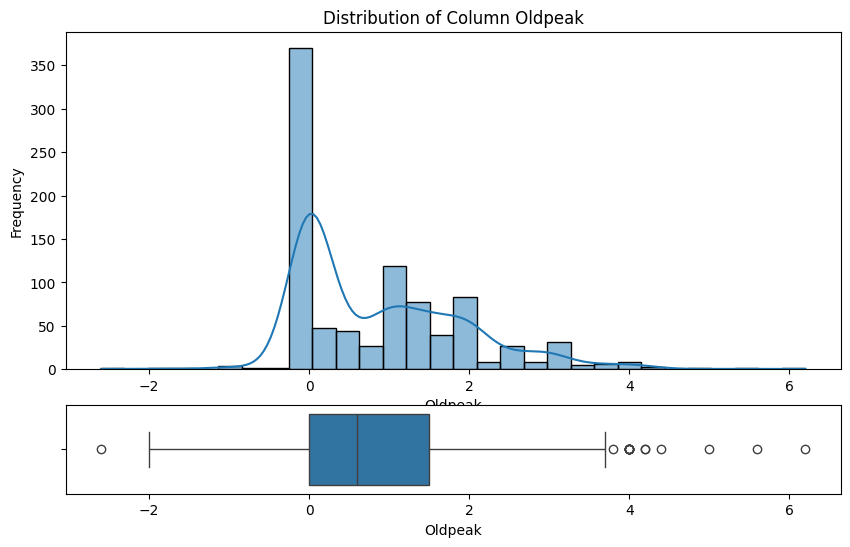

Skewness: -0.19593302867569365
Kurtosis: -0.3861396123864571
The data is approximately symmetric (Gaussian-like).

Skewness: 0.1798393100516288
Kurtosis: 3.2712509168295356
The data is approximately symmetric (Gaussian-like).

Skewness: -0.6100864307268192
Kurtosis: 0.11820846851766742
The data is skewed.

Skewness: -0.14435941846180994
Kurtosis: -0.4482478199521531
The data is approximately symmetric (Gaussian-like).

Skewness: 1.0228720218107528
Kurtosis: 1.2030636840120112
The data is skewed.



In [49]:
def check_distr_outliers(df, column):
  # Histogram and boxplot to visualize outliers
  data = df[column]

  # Create a figure with subplots
  fig = plt.figure(figsize=(10, 6))
  grid = plt.GridSpec(4, 1, hspace=0.4)

  # Add a histogram in the first subplot
  ax_hist = fig.add_subplot(grid[:-1, 0])
  sns.histplot(data, bins=30, kde=True, ax=ax_hist)
  ax_hist.set_ylabel('Frequency')
  ax_hist.set_title('Distribution of Column '+column)

  # Add a horizontal box plot in the second subplot
  ax_box = fig.add_subplot(grid[-1, 0])
  sns.boxplot(data, ax=ax_box, orient='h')
  ax_box.set_xlabel(column)

  # Show the plot
  plt.show()
check_distr_outliers(raw_heart_df,'Age')
check_distr_outliers(raw_heart_df,'RestingBP')
check_distr_outliers(raw_heart_df,'Cholesterol')
check_distr_outliers(raw_heart_df,'MaxHR')
check_distr_outliers(raw_heart_df,'Oldpeak')


def check_outliers(df, column):
  print("Skewness:", df[column].skew())
  print("Kurtosis:", df[column].kurt())
  if abs(df[column].skew()) < 0.5:
      print("The data is approximately symmetric (Gaussian-like).\n")
  else:
      print("The data is skewed.\n")

check_outliers(raw_heart_df,'Age')
check_outliers(raw_heart_df,'RestingBP')
check_outliers(raw_heart_df,'Cholesterol')
check_outliers(raw_heart_df,'MaxHR')
check_outliers(raw_heart_df,'Oldpeak')

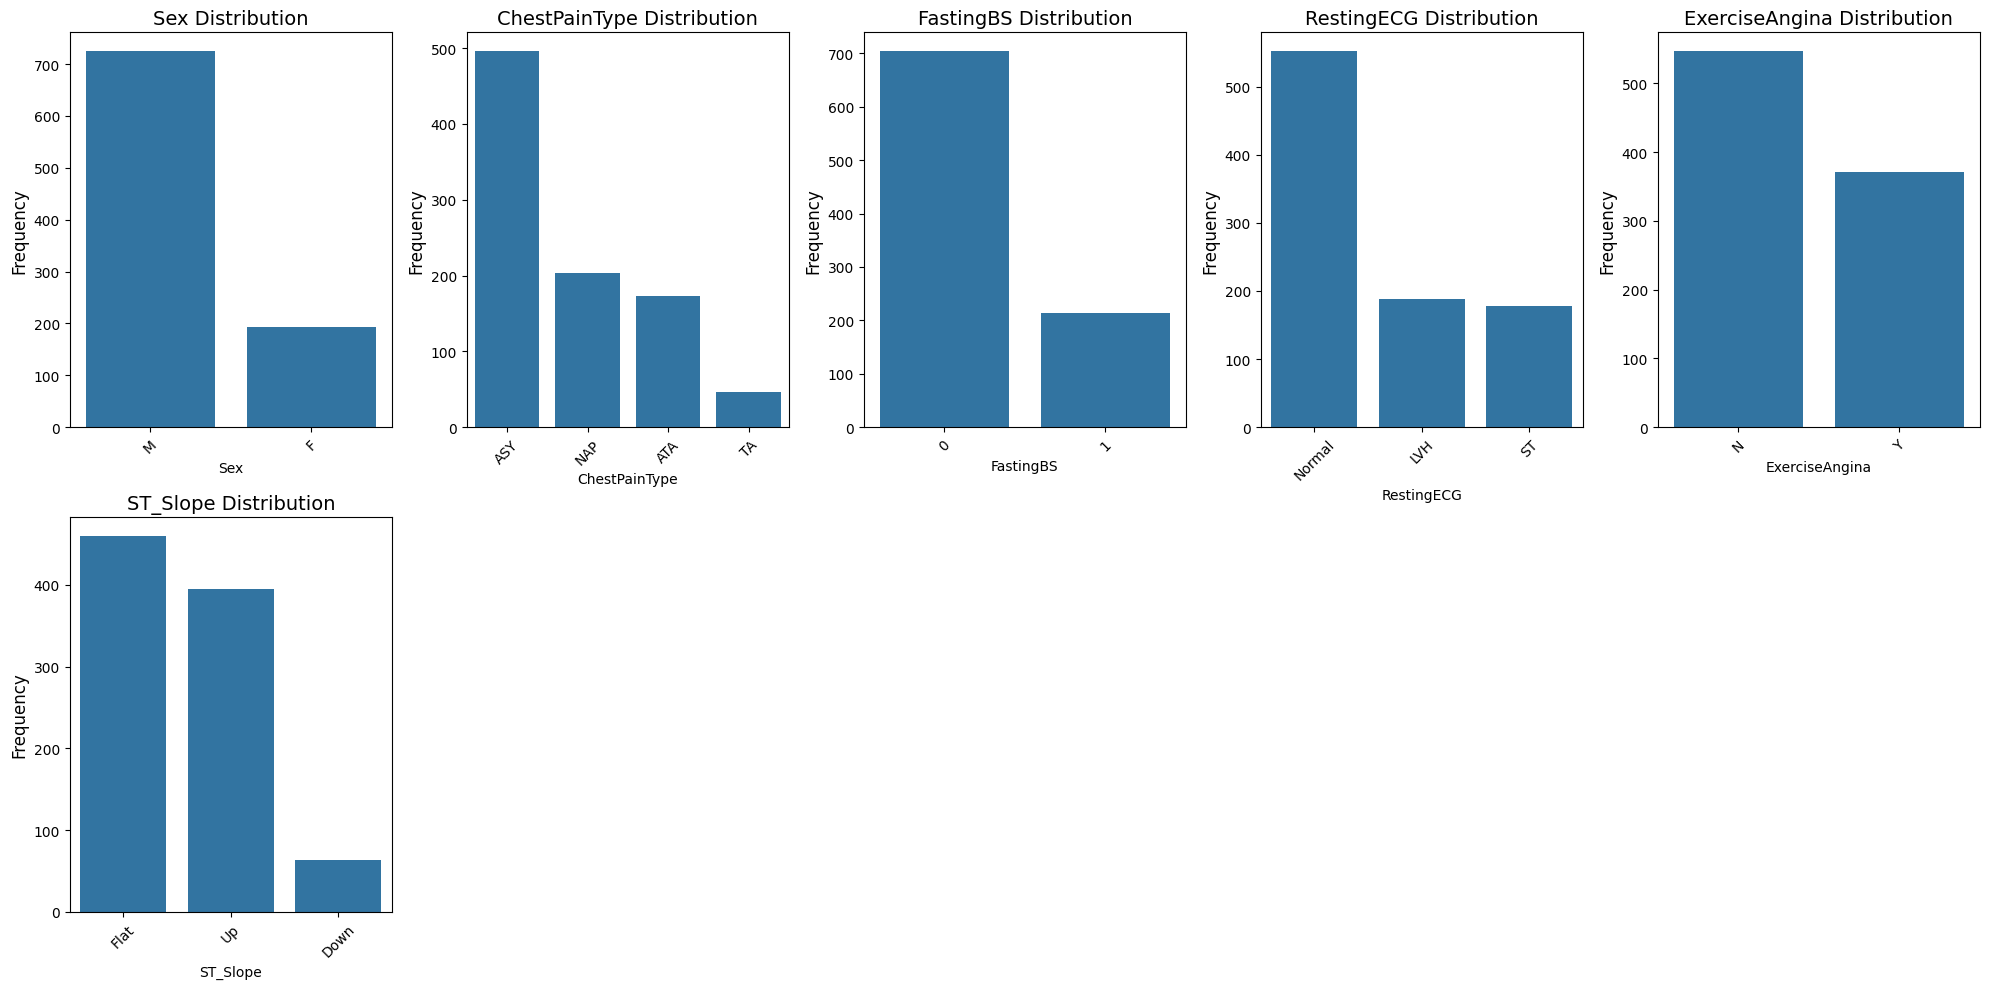

In [50]:
def plot_frequency_distribution(df):
  # Select categorical columns
  categorical_columns = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']

  # Define maximum plots per row
  max_plots_per_row = 5

  # Number of rows needed
  num_cols = len(categorical_columns)
  num_rows = (num_cols // max_plots_per_row) + (num_cols % max_plots_per_row > 0)

  # Create subplots
  fig, axes = plt.subplots(num_rows, max_plots_per_row, figsize=(20, num_rows * 5))
  axes = axes.flatten()  # Flatten to simplify indexing

  # Plot each categorical variable
  for i, col in enumerate(categorical_columns):
      category_counts = df[col].value_counts()  # Get category frequencies
      sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[i])
      axes[i].set_title(f'{col} Distribution', fontsize=14)

      axes[i].set_ylabel('Frequency', fontsize=12)
      axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

  # Hide unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

plot_frequency_distribution(raw_heart_df.copy())

In [51]:
print(raw_heart_df['Sex'].value_counts(normalize=True),'\n')
print(raw_heart_df['ChestPainType'].value_counts(normalize=True),'\n')
print(raw_heart_df['RestingECG'].value_counts(normalize=True),'\n')
print(raw_heart_df['ExerciseAngina'].value_counts(normalize=True),'\n')
print(raw_heart_df['ST_Slope'].value_counts(normalize=True),'\n')
print(raw_heart_df['FastingBS'].value_counts(normalize=True),'\n')


Sex
M    0.78976
F    0.21024
Name: proportion, dtype: float64 

ChestPainType
ASY    0.540305
NAP    0.221133
ATA    0.188453
TA     0.050109
Name: proportion, dtype: float64 

RestingECG
Normal    0.601307
LVH       0.204793
ST        0.193900
Name: proportion, dtype: float64 

ExerciseAngina
N    0.595861
Y    0.404139
Name: proportion, dtype: float64 

ST_Slope
Flat    0.501089
Up      0.430283
Down    0.068627
Name: proportion, dtype: float64 

FastingBS
0    0.766885
1    0.233115
Name: proportion, dtype: float64 



## Inconsistencies

In [52]:
df = raw_heart_df.copy()

# Check categorical distribution for all object or categorical columns
categorical_columns = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']

for col in categorical_columns:
    print(f"--- {col} ---")
    counts = df[col].value_counts()  # Frequency
    percentages = df[col].value_counts(normalize=True) * 100  # Percentage
    print(pd.DataFrame({'Count': counts, 'Percentage': percentages}).sort_values(by='Count', ascending=False))
    print("\n")


--- Sex ---
     Count  Percentage
Sex                   
M      725   78.976035
F      193   21.023965


--- ChestPainType ---
               Count  Percentage
ChestPainType                   
ASY              496   54.030501
NAP              203   22.113290
ATA              173   18.845316
TA                46    5.010893


--- FastingBS ---
           Count  Percentage
FastingBS                   
0            704   76.688453
1            214   23.311547


--- RestingECG ---
            Count  Percentage
RestingECG                   
Normal        552   60.130719
LVH           188   20.479303
ST            178   19.389978


--- ExerciseAngina ---
                Count  Percentage
ExerciseAngina                   
N                 547   59.586057
Y                 371   40.413943


--- ST_Slope ---
          Count  Percentage
ST_Slope                   
Flat        460   50.108932
Up          395   43.028322
Down         63    6.862745




<b>Implementation Notes: </b>
- Imbalanced Columns: Sex
- No duplicated data.
- No datatype transformation required.

# Statistical Summary

In [53]:
# Numeric Variables
raw_heart_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


<b>Statistical Notes:</b>

Categorical Features:

* There are 78% females and 21% males.
* ChestPainType  5% report Typical Angina Pain, 54% are asymptomatic patients, 22% Do not report angina pain, 19% report Non Angina pain.
* Resting Electrocardigram: 19% indicate potential issues, 20% Ventricular Hypertrophy abnormally 60% no significant abnormalies.
* ExerciseAngina: 40% report angina during exercises, 60% do not report angina.  
* ST_Slope: 7% of patiensts have indicative of artery heart disease while 40% report limited heart response during exercises and 50% have normaal response to exercises.

Numeric Features:

* Age: The average is around 53.5 and the ages are from 28 years old and 77 years old. 50 % of patients are less than 54 years old and 75% are less than 60 years old. Most ages in the dataset fall within 9.43 years around the mean.

* RestingBP (Resting Blood Pressure): The average is 132. Values range widely from 0 (likely outlier or data issue) to 200 mmHg.  25% of patients have a resting pressure bellow 120.

* The average cholesterol level is 198.8 mg/dL. The range (0 to 603 mg/dL) also suggests possible outliers (0 could indicate missing or invalid data). 25% of patients have a total cholesterol bellow 173%.

* MaxHR (Maximum Heart Rate):
The average max heart rate is 136.8 bpm, with a range from 60 to 202 bpm.

* Oldpeak (ST Depression):
Average is 0.887, with values ranging from -2.6 to 6.2.

# EDA -  Multivariate Analysis

### Numerical vs Numerical

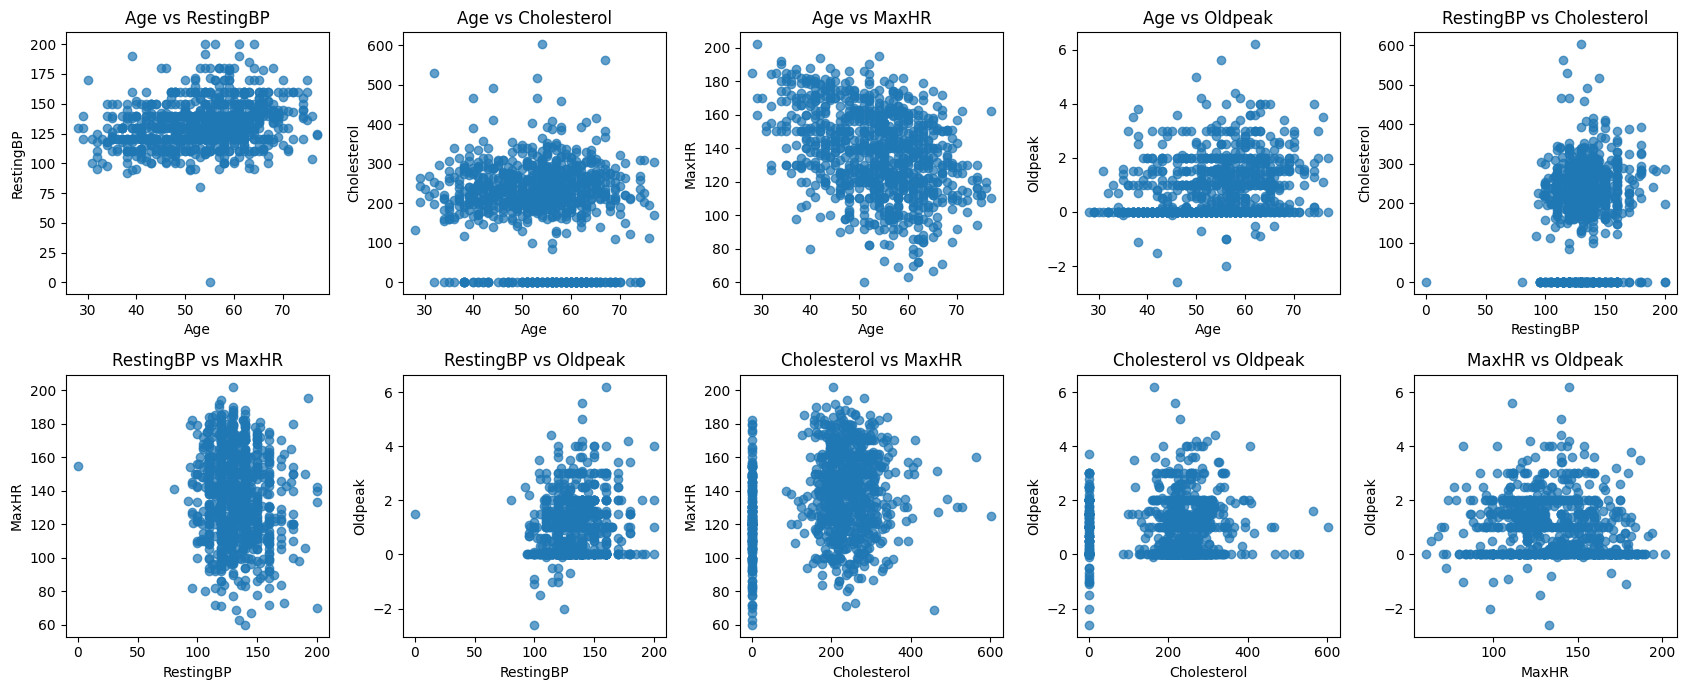

In [54]:
import itertools
def plot_scatter_matrix(df):
  # Create a sample dataset for demonstration
  np.random.seed(42)


  # Define the columns and generate all 2-combinations
  columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
  combinations = list(itertools.combinations(columns, 2))

  # Set up the subplot grid (2 rows, 5 columns)
  fig, axes = plt.subplots(2, 5, figsize=(17, 7))
  axes = axes.flatten()

  # Plot the scatter plots for the first 10 combinations
  for i, (col1, col2) in enumerate(combinations[:10]):
      ax = axes[i]
      ax.scatter(df[col1], df[col2], alpha=0.7)
      ax.set_xlabel(col1)
      ax.set_ylabel(col2)
      ax.set_title(f'{col1} vs {col2}')

  # Adjust layout for clarity
  plt.tight_layout()
  plt.show()

plot_scatter_matrix(raw_heart_df.copy())

<b>Notes</b>

Scatter plots

- Age vs MaxHR: A slight negative trend is visible: younger individuals tend to have higher MaxHR. This is expected since MaxHR decreases with age as part of normal cardiovascular physiology.
- No Strong Linear Relationships: Most of these variables show weak or no linear relationships.
- Outliers: Several plots (Cholesterol and RestingBP) show clear outliers that might need to be addressed.

### Numerical vs Categorical


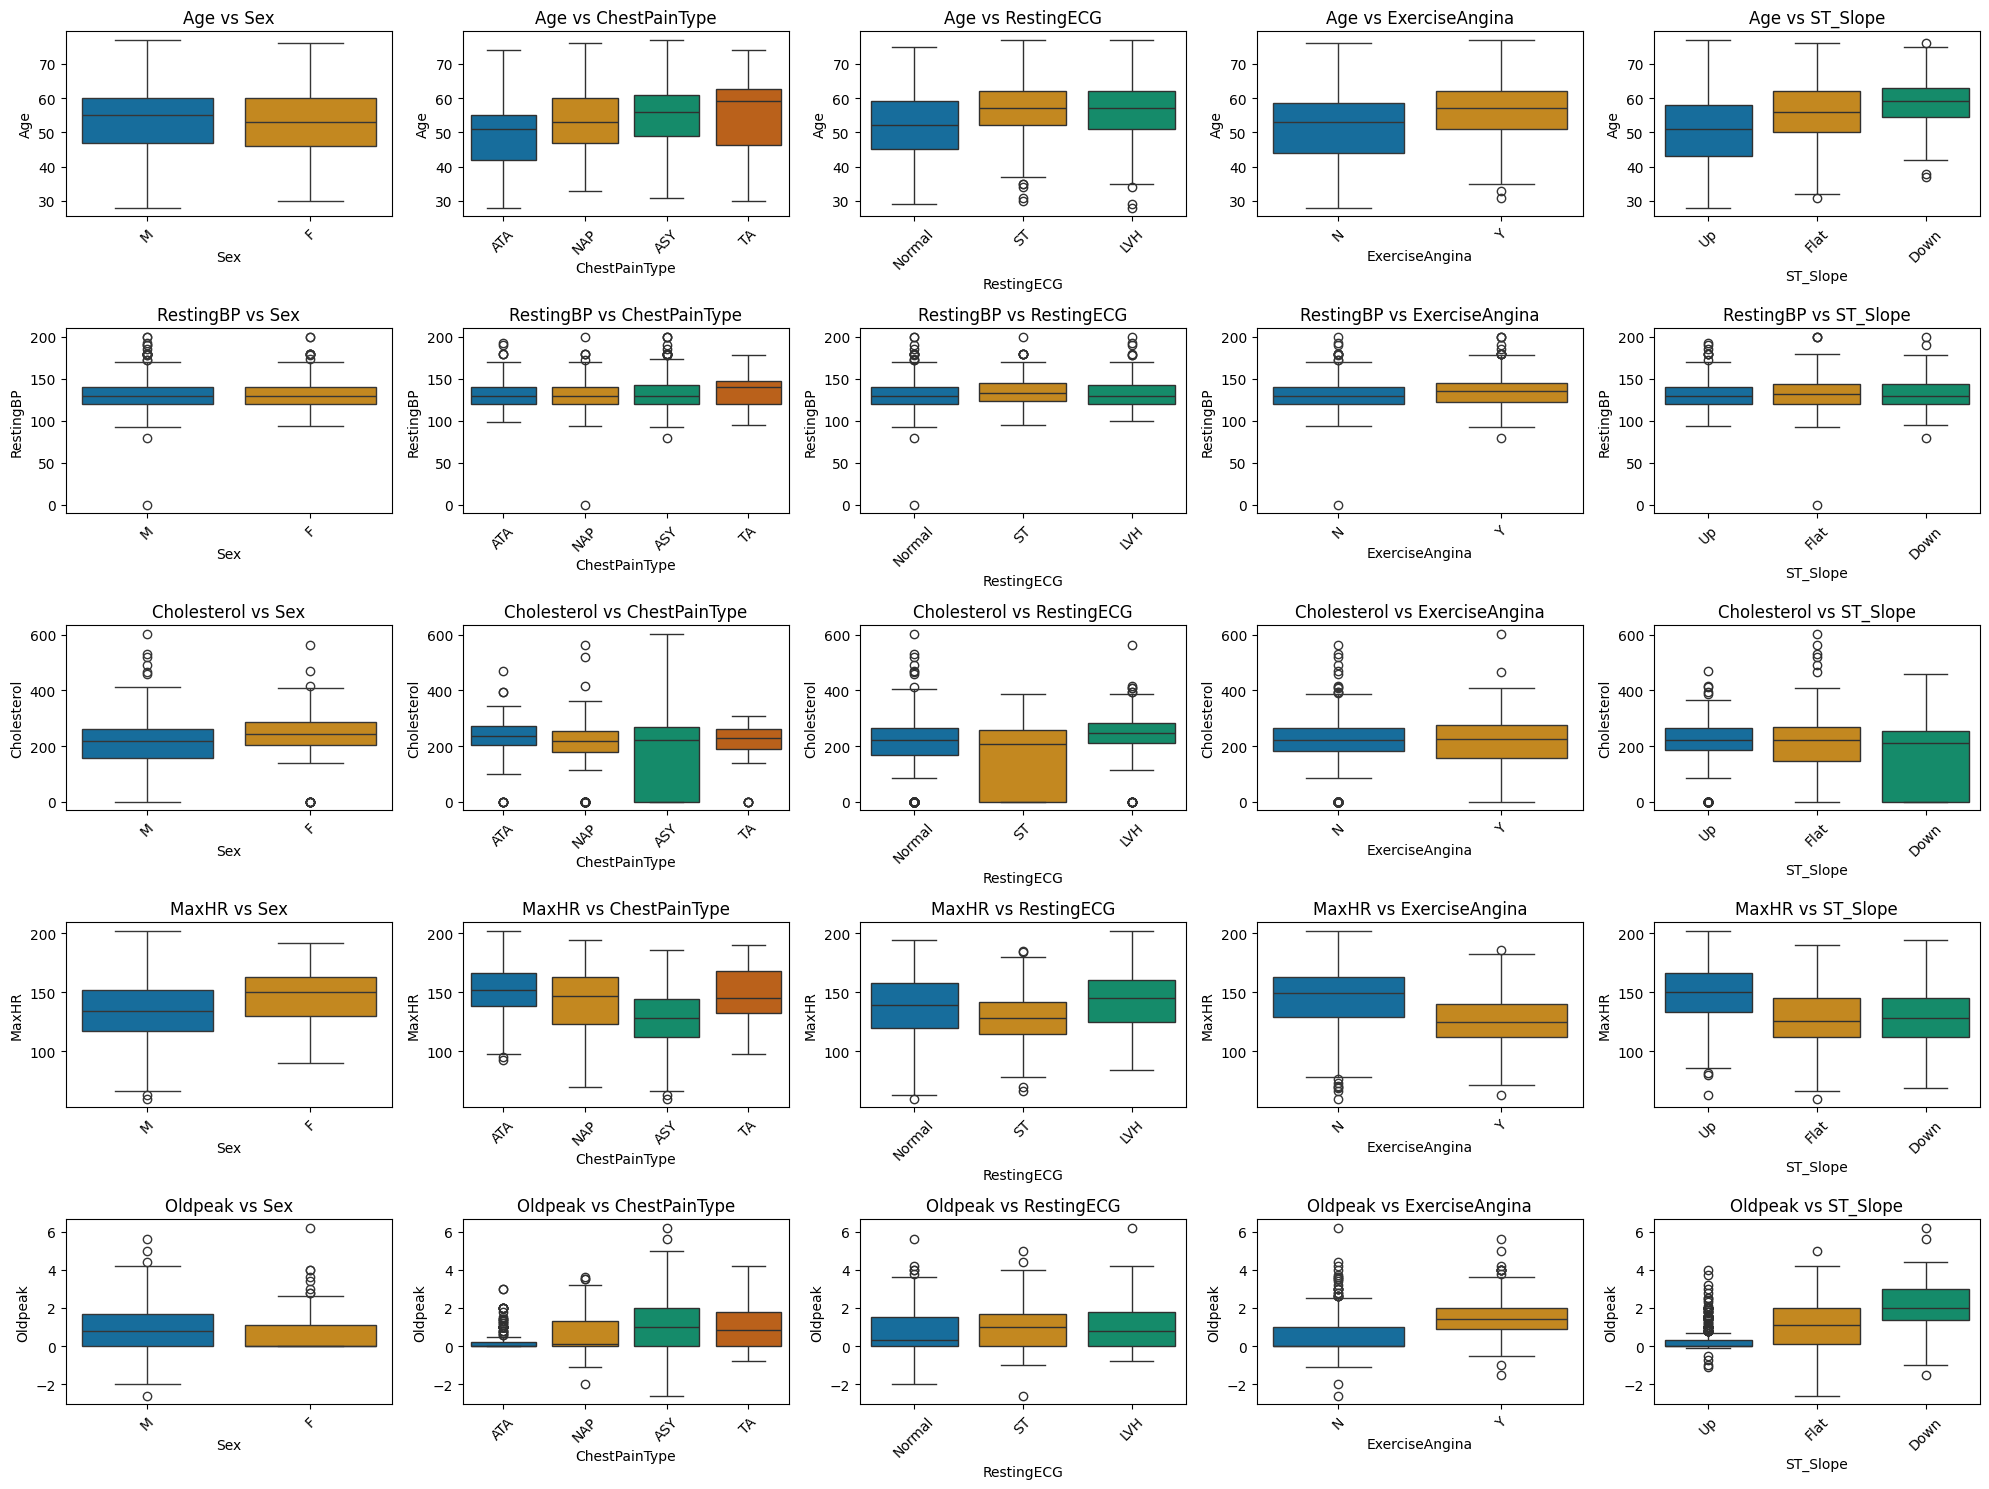

In [55]:
def plot_boxplots(df,numerical_columns,categorical_columns):

  # Define numerical and categorical columns
  numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
  categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

  # Create a figure with a 5x5 grid for 25 plots
  fig, axes = plt.subplots(5, 5, figsize=(20, 15))

  # Plot relationships between numerical and categorical columns
  for i, num_col in enumerate(numerical_columns):
      for j, cat_col in enumerate(categorical_columns):
          ax = axes[i, j]  # Determine subplot location
          sns.boxplot(data=df, x=cat_col, y=num_col, ax=ax, hue=cat_col, dodge=False, palette="colorblind")
          ax.set_title(f'{num_col} vs {cat_col}')
          ax.set_xlabel(cat_col)
          ax.set_ylabel(num_col)
          ax.tick_params(axis='x', rotation=45)
          #ax.legend_.remove()  # Remove redundant legends for clarity

  # Adjust layout
  plt.tight_layout()
  plt.show()
plot_boxplots(raw_heart_df.copy(),numerical_columns,categorical_columns)

<b>Notes</b>

Consistencies:

* Age vs ChestPainType:
Individuals with TA (typical angina) tend to be older, with a higher median age compared to other types.
ASY (asymptomatic) patients also span a wide age range, with a slightly lower median than TA.
NAP (non-anginal pain) and TA show more variability in age compared to the others.

* Age vs ExerciseAngina:
Individuals with Exercise Angina (Y) tend to be slightly older on average than those without (N).
The IQR is narrower for those without angina, indicating less variability in their ages.*

* Age vs ST_Slope:
Those with a Flat ST Slope tend to be older, while individuals with a Downward Slope have a slightly higher age variability.
Upward Slope shows younger patients on average.

* Cholesterol vs ChestPainType:
Patients with ASY (asymptomatic chest pain) have the highest cholesterol median and variability compared to other types.
TA (typical angina) and NAP (non-anginal pain) have lower and more consistent cholesterol levels.

* Cholesterol vs RestingECG:
The LVH (left ventricular hypertrophy) group has slightly higher cholesterol medians compared to Normal or ST groups.
Variability appears similar across all ECG categories.

* Cholesterol vs ExerciseAngina:
Patients with Exercise Angina (Y) tend to have slightly higher cholesterol levels, although the difference in medians is minor.
There are more high-value outliers in the group without angina (N).

* Cholesterol vs ST_Slope:
Patients with a Downward ST Slope have the highest median cholesterol levels and variability.
The Flat and Upward slope groups show lower and more consistent cholesterol distributions.

* MaxHR:
MaxHR is notably higher in patients without Exercise Angina and those with an Upward ST Slope.
Differences between groups for most other categories (e.g., sex, chest pain) are minor.
* ExerciseAngina: Exercise-induced angina is associated with higher Oldpeak values.
* ST_Slope: Patients with Flat or Downward ST Slopes have significantly higher Oldpeak values, while those with Upward Slopes have much lower values.

### Categorical vs Categorical

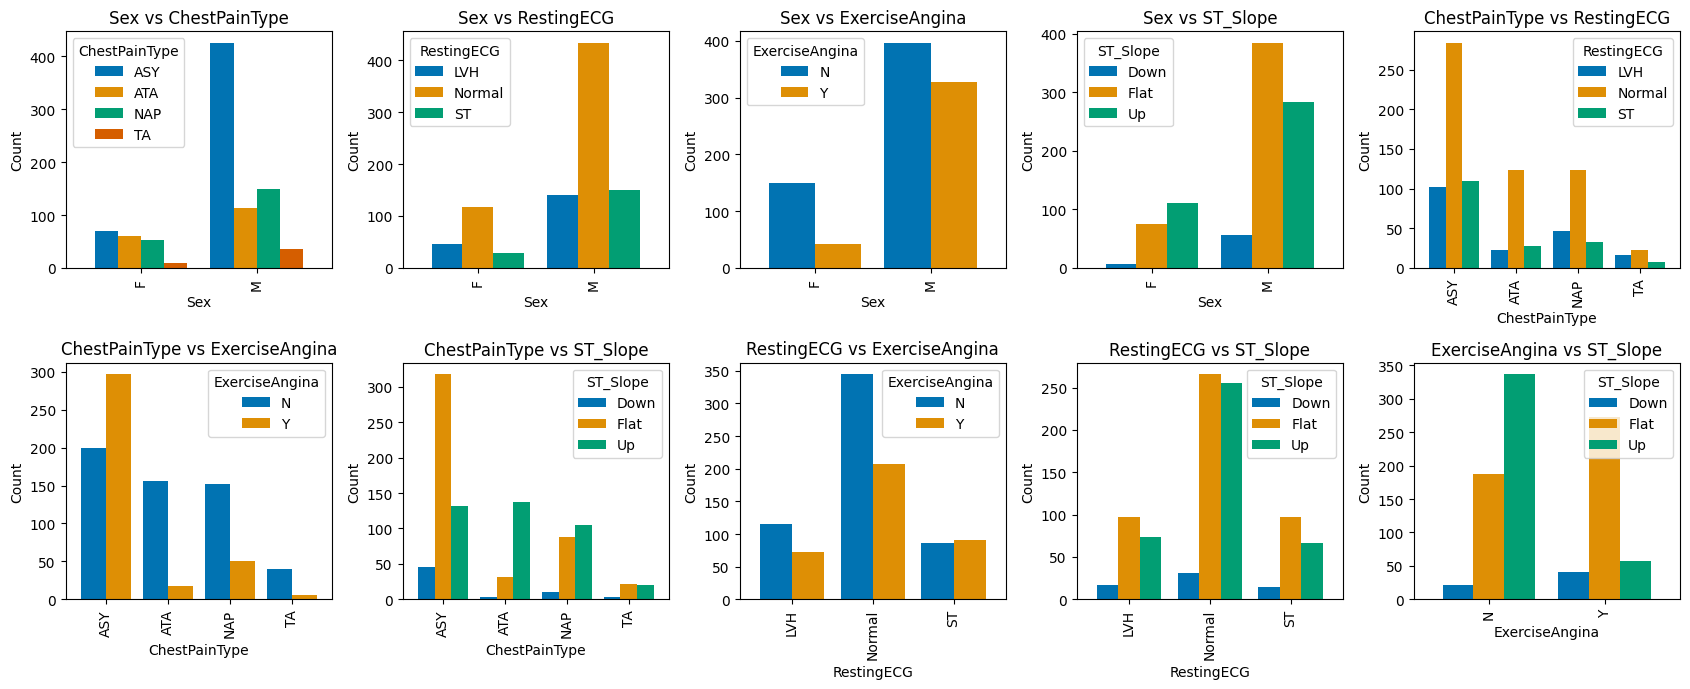

In [56]:
def plot_grouped_stacked_bar_charts(df):
  # Simulate a dataset for demonstration purposes
  np.random.seed(0)


  # Define pairs of columns to create grouped bar charts
  pairs = [
      ('Sex', 'ChestPainType'),
      ('Sex', 'RestingECG'),
      ('Sex', 'ExerciseAngina'),
      ('Sex', 'ST_Slope'),
      ('ChestPainType', 'RestingECG'),
      ('ChestPainType', 'ExerciseAngina'),
      ('ChestPainType', 'ST_Slope'),
      ('RestingECG', 'ExerciseAngina'),
      ('RestingECG', 'ST_Slope'),
      ('ExerciseAngina', 'ST_Slope')
  ]

  # Define a colorblind-friendly palette from Seaborn
  sns_palette = sns.color_palette("colorblind", n_colors=10)

  # Create a figure and axes
  fig, axes = plt.subplots(2, 5, figsize=(17, 7))

  # Plot grouped bar charts for each pair of columns with a colorblind-friendly palette
  for i, (col1, col2) in enumerate(pairs):
      ax = axes[i // 5, i % 5]  # Determine subplot location
      crosstab = pd.crosstab(df[col1], df[col2])
      crosstab.plot(kind='bar', ax=ax, color=sns_palette[:len(crosstab.columns)], legend=True, width=0.8)
      ax.set_title(f'{col1} vs {col2}')
      ax.set_xlabel(col1)
      ax.set_ylabel('Count')
      ax.legend(title=col2, loc='best')

  # Adjust layout
  plt.tight_layout()
  plt.show()

plot_grouped_stacked_bar_charts(raw_heart_df.copy())

<b>Notes</b>

* Sex vs ChestPainType:
Males (M) have significantly more cases of ASY (asymptomatic chest pain) compared to other types.
Females (F) have relatively balanced counts across NAP (non-anginal pain), ATA (atypical angina), and ASY, with fewer cases overall.

* Sex vs ExerciseAngina:
Exercise-induced angina (Y) is more common in males than in females.
In both sexes, Exercise Angina (N) (no angina) has higher counts than angina (Y).


* ChestPainType vs RestingECG:
Most ASY (asymptomatic chest pain) cases are associated with Normal ECG.
LVH and ST are less common across all chest pain types.
NAP and ATA are also predominantly linked with Normal ECG.

* ChestPainType vs ExerciseAngina:
ASY has the highest counts of Exercise Angina (Y).
Other chest pain types (e.g., ATA, NAP) are predominantly associated with Exercise Angina (N).

* ChestPainType vs ST_Slope:
ASY cases are mostly associated with a Flat ST Slope.
Upward Slope is more common in ATA and NAP cases.
Downward Slope is less frequent but appears more in ASY.

### Correlation Matrix


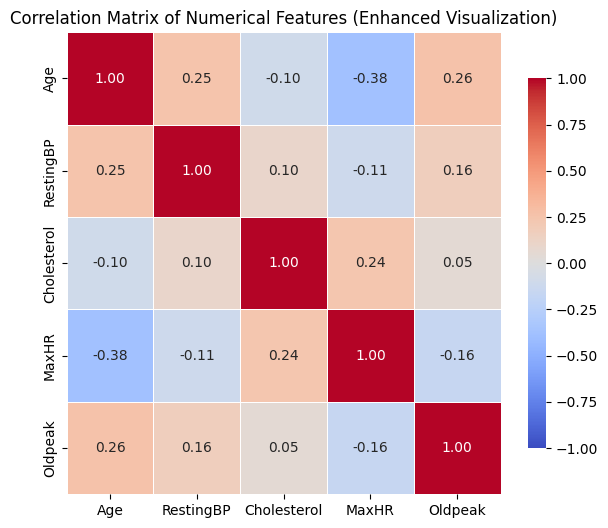

In [57]:
def correlation_plot(df,numerical_columns):
  correlation_matrix = df[numerical_columns].corr()
  # Plot the correlation matrix as a heatmap with a new color palette
  plt.figure(figsize=(7, 6))
  sns.heatmap(
      correlation_matrix,
      annot=True,
      cmap="coolwarm",  # High-contrast color palette
      fmt=".2f",
      vmin=-1,
      vmax=1,
      linewidths=0.5,  # Add gridlines for clarity
      cbar_kws={"shrink": 0.8}  # Adjust the size of the color bar
  )
  plt.title("Correlation Matrix of Numerical Features (Enhanced Visualization)")
  plt.show()
correlation_plot(raw_heart_df.copy(),numerical_columns)

Highest correlations:
- Negative: Age and MaxHR (-0.38).
- Positive: Age and Oldpeak (0.26).

Overall weak correlations:

Most pairwise correlations are weak (-0.25 and 0.25), suggesting that these features are relatively independent.


# Data Preprocessing

### Handle Outliers



### Removing Outliers from Resting Blood Pressure


In [58]:
 #Resting BP:   Systolic Measurement  (<70,>200)
def detect_outliers(df, column):

  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
  #print(lower_bound,upper_bound)
  return outliers

print('Outliers RestingBP:', len(detect_outliers(raw_heart_df,'RestingBP')))
print('Outliers Cholesterol:', len(detect_outliers(raw_heart_df,'Cholesterol')))
print('Outliers MaxHR:', len(detect_outliers(raw_heart_df,'MaxHR')))
print('Outliers Oldpeak:', len(detect_outliers(raw_heart_df,'Oldpeak')))

Outliers RestingBP: 28
Outliers Cholesterol: 183
Outliers MaxHR: 2
Outliers Oldpeak: 16


In [59]:

def detect_inconsistencies(df, column,lower_bound,upper_bound):
  df_cleaned = df.copy()
  return len(df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)])


def removing_inconsistencies(df, column,lower_bound,upper_bound):
  df_cleaned = df.copy()
  df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] < upper_bound)]
  return df_cleaned

#incorrect recording, unit mismatches, or typographical mistakes.

print('Outliers RestingBP:', detect_inconsistencies(raw_heart_df,'RestingBP',70,200))
print('Outliers Cholesterol:', detect_inconsistencies(raw_heart_df,'Cholesterol',70,1200))
print('Outliers MaxHR:', detect_inconsistencies(raw_heart_df,'MaxHR',20,220))
print('Outliers Oldpeak:', detect_inconsistencies(raw_heart_df,'Oldpeak',0,10))


heart_df_cleaned = raw_heart_df.copy()
heart_df_cleaned = removing_inconsistencies(heart_df_cleaned, 'RestingBP',50,200)
heart_df_cleaned = removing_inconsistencies(heart_df_cleaned, 'Cholesterol',70,1200)
heart_df_cleaned = removing_inconsistencies(heart_df_cleaned, 'MaxHR',20,220)
heart_df_cleaned = removing_inconsistencies(heart_df_cleaned, 'Oldpeak',-3,5)


Outliers RestingBP: 1
Outliers Cholesterol: 172
Outliers MaxHR: 0
Outliers Oldpeak: 13


### Missing Values and Outliers Notes.
### Asumptions for Inconsistencies in the data:

1.- Resting BP:   Systolic Measurement  (<70,>200)

  Inconsistencies to Flag in RestingBP:
  - Too Low:
    Systolic <70 mm Hg or Diastolic <40 mm Hg is likely unrealistic or represents severe hypotension that would likely require medical attention.
    Values below these thresholds should be flagged for verification.
  - Too High:
    Systolic >200 mm Hg or Diastolic >120 mm Hg is extremely rare and may indicate severe hypertension or data entry errors.
    Flag values exceeding these thresholds for review.
    Biologically Impossible Values:
    Negative or Zero Values: Blood pressure cannot be zero or negative; these should be removed or corrected.
    
2.- Cholesterol: (<100,>600) Total Cholesterol
  
  Potential Errors or Inconsistencies:
  - Too Low:
    Values '<'100 mg/dL are rare and may indicate:
    Data entry errors.
    Severe malnutrition or metabolic disorders (e.g., hypocholesterolemia).
  - Too High:
    Values >600 mg/dL are uncommon and may reflect:
    Genetic conditions like familial hypercholesterolemia.
    Severe data inconsistencies if >1,200 mg/dL.
    Unrealistic or Biologically Impossible Values:
    Negative values or values >1,200 mg/dL are biologically impossible and must be corrected.

3.- Maximum Heart Rate (MaxHR): (<100, >220)

  Outliers to Flag:
    - Too High: Values > 220 bpm are generally unrealistic unless the person is very young or in a rare extreme case.
    - Too Low: Values < 100 bpm are unlikely for MaxHR unless severe cardiovascular conditions or errors exist.
    HR < 30 bpm is life-threatening and warrants immediate medical attention.

4.- OldPeak: (<0, >5)

  Inconsistencies to Flag:
    - Negative Oldpeak Values:
    Negative values (<0 mm) are biologically inconsistent for ST depression or elevation unless your dataset explicitly includes them to represent elevation in another context.
    - Extreme Positive Values:
    Values >5 mm are extremely rare and may indicate a data entry error unless explicitly verified by clinical context.


In [60]:
print('Outliers RestingBP:', detect_inconsistencies(heart_df_cleaned,'RestingBP',70,200))
print('Outliers Cholesterol:', detect_inconsistencies(heart_df_cleaned,'Cholesterol',70,1200))
print('Outliers MaxHR:', detect_inconsistencies(heart_df_cleaned,'MaxHR',20,220))
print('Outliers Oldpeak:', detect_inconsistencies(heart_df_cleaned,'Oldpeak',0,10))

Outliers RestingBP: 0
Outliers Cholesterol: 0
Outliers MaxHR: 0
Outliers Oldpeak: 1


In [61]:

print('Outliers RestingBP:', len(detect_outliers(heart_df_cleaned,'RestingBP')))
print('Outliers Cholesterol:', len(detect_outliers(heart_df_cleaned,'Cholesterol')))
print('Outliers MaxHR:', len(detect_outliers(heart_df_cleaned,'MaxHR')))
print('Outliers Oldpeak:', len(detect_outliers(heart_df_cleaned,'Oldpeak')))

Outliers RestingBP: 18
Outliers Cholesterol: 23
Outliers MaxHR: 0
Outliers Oldpeak: 11


In [62]:
heart_df_cleaned.shape


(741, 12)

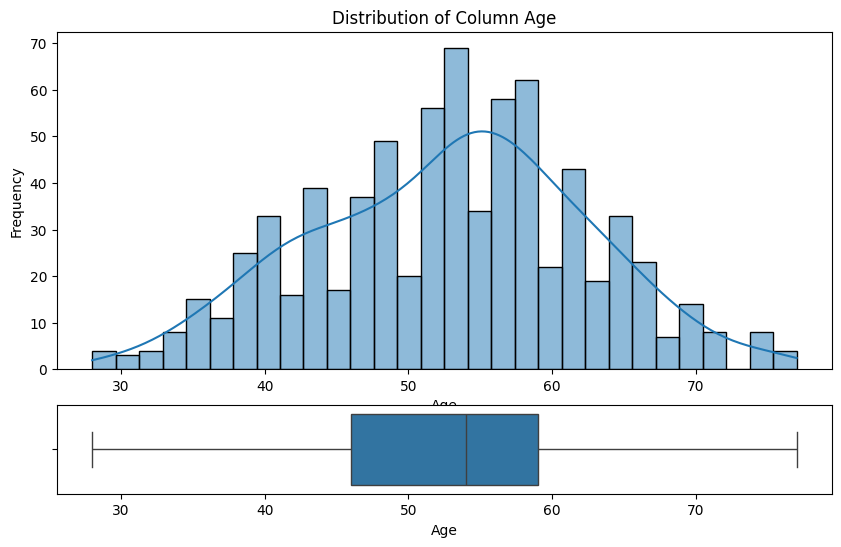

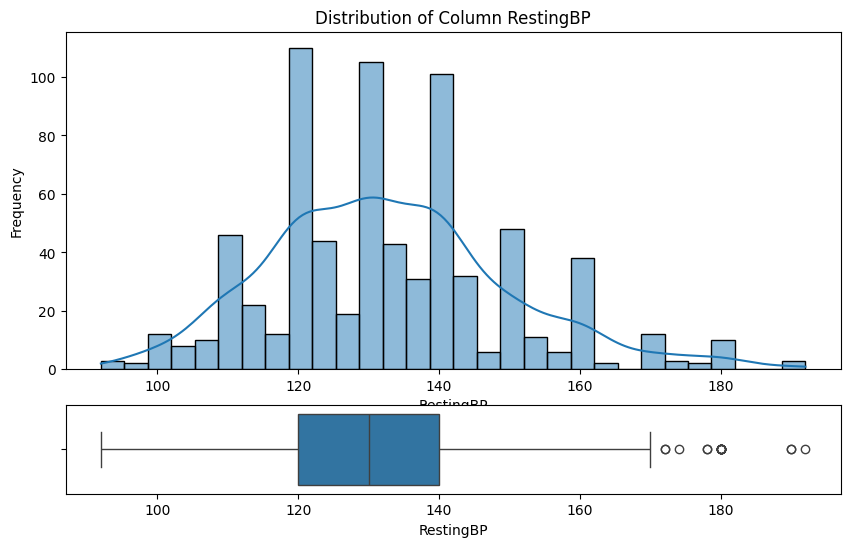

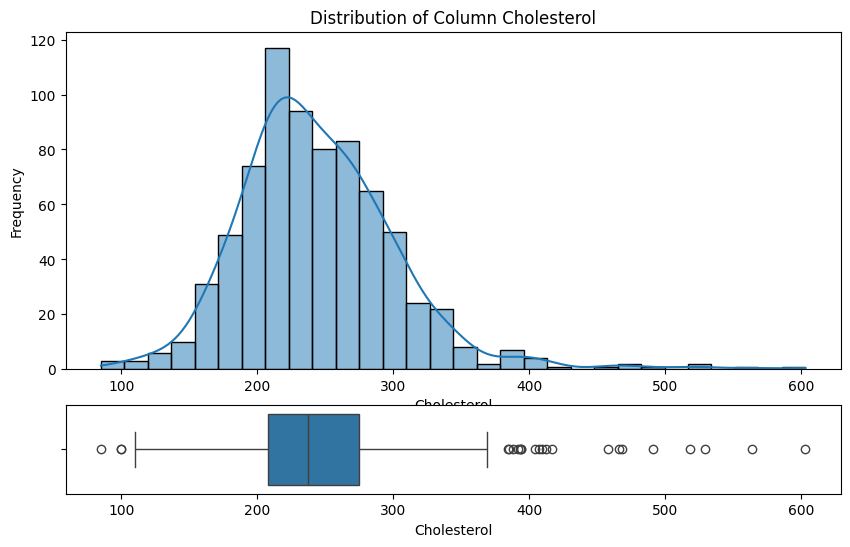

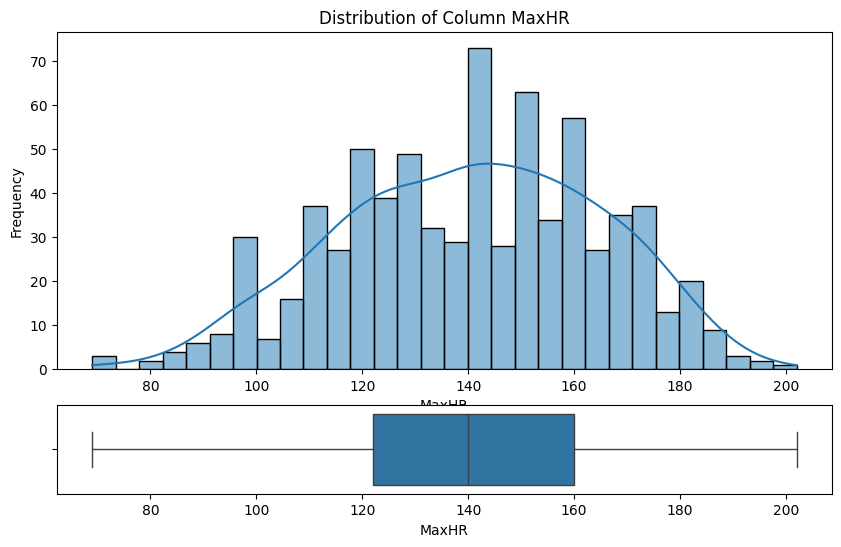

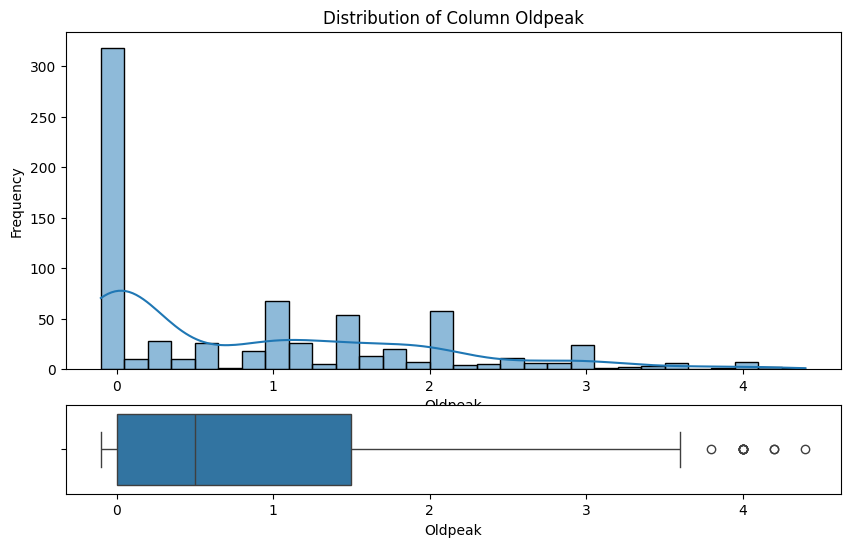

Skewness: -0.0986844874908184
Kurtosis: -0.39856292232070256
The data is approximately symmetric (Gaussian-like).

Skewness: 0.5304972012278868
Kurtosis: 0.4267583617064141
The data is skewed.

Skewness: 1.237751016103991
Kurtosis: 4.525086176510433
The data is skewed.

Skewness: -0.16780507551352686
Kurtosis: -0.5603062161003081
The data is approximately symmetric (Gaussian-like).

Skewness: 1.0334102429558165
Kurtosis: 0.31701532415258526
The data is skewed.



In [63]:
check_distr_outliers(heart_df_cleaned,'Age')
check_distr_outliers(heart_df_cleaned,'RestingBP')
check_distr_outliers(heart_df_cleaned,'Cholesterol')
check_distr_outliers(heart_df_cleaned,'MaxHR')
check_distr_outliers(heart_df_cleaned,'Oldpeak')

check_outliers(heart_df_cleaned,'Age')
check_outliers(heart_df_cleaned,'RestingBP')
check_outliers(heart_df_cleaned,'Cholesterol')
check_outliers(heart_df_cleaned,'MaxHR')
check_outliers(heart_df_cleaned,'Oldpeak')

 # EDA - Feature Engineering


## Check Gaussian Distribution

In [64]:
def check_outliers(df, column):
  print("Skewness:", df[column].skew())
  print("Kurtosis:", df[column].kurt())
  if abs(df[column].skew()) < 0.5:
      print("The data is approximately symmetric (Gaussian-like).\n")
  else:
      print("The data is skewed.\n")

check_outliers(heart_df_cleaned,'Age')
check_outliers(heart_df_cleaned,'RestingBP')
check_outliers(heart_df_cleaned,'Cholesterol')
check_outliers(heart_df_cleaned,'MaxHR')
check_outliers(heart_df_cleaned,'Oldpeak')

Skewness: -0.0986844874908184
Kurtosis: -0.39856292232070256
The data is approximately symmetric (Gaussian-like).

Skewness: 0.5304972012278868
Kurtosis: 0.4267583617064141
The data is skewed.

Skewness: 1.237751016103991
Kurtosis: 4.525086176510433
The data is skewed.

Skewness: -0.16780507551352686
Kurtosis: -0.5603062161003081
The data is approximately symmetric (Gaussian-like).

Skewness: 1.0334102429558165
Kurtosis: 0.31701532415258526
The data is skewed.



In [65]:
df_no_outliers = heart_df_cleaned.copy()


In [66]:
df_no_outliers['Sex'] = df_no_outliers['Sex'].map({'M': 1, 'F': 0})
df_no_outliers['ExerciseAngina'] = df_no_outliers['ExerciseAngina'].map({'Y': 1, 'N': 0})

### Encoding

In [67]:
df_no_outliers.head(2)
print(set(df_no_outliers['HeartDisease']))
print(len(df_no_outliers),df_no_outliers.shape)

{0, 1}
741 (741, 12)


In [68]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse

# Fit and transform the categorical columns
encoded = encoder.fit_transform(df_no_outliers[['ChestPainType', 'RestingECG', 'ST_Slope']])

# Create a DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['ChestPainType', 'RestingECG', 'ST_Slope']))

# Verify index alignment
assert len(encoded_df) == len(df_no_outliers), "Encoded DataFrame rows don't match the original DataFrame."
encoded_df.index = df_no_outliers.index  # Ensure the indices align

# Add the encoded columns directly to the original DataFrame
df_no_outliers = df_no_outliers.drop(columns=['ChestPainType', 'RestingECG', 'ST_Slope'])  # Drop original categorical columns
df_no_outliers = pd.concat([df_no_outliers, encoded_df], axis=1)  # Combine without reindexing

# Verify the final DataFrame shape
df_no_outliers.head(3)
print(f"Final shape: {df_no_outliers.shape}")

df_encoded = df_no_outliers.copy()

Final shape: (741, 19)


In [69]:
df_encoded.head(3)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180,0,156,0,1.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283,0,98,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [70]:
df_encoded.shape

(741, 19)

In [71]:
set(df_encoded['HeartDisease'])

{0, 1}

In [72]:
y = df_encoded['HeartDisease']

In [73]:
X = df_encoded.drop('HeartDisease', axis=1,inplace=False)
X.head(2)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180,0,156,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Splitting, Standarizing, Normalizing, Training, Fitting and Evaluating Models

In [74]:
test_size=0.3
val_size=0.5
random_state=42

# Step 1: Split into Train + Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state,stratify=y)

# Step 2: Split Temp into Validation and Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state,stratify=y_temp)


# Normalization: Scale features to range [0, 1]
min_max_scaler = MinMaxScaler()
X_train_normalized = min_max_scaler.fit_transform(X_train)
X_val_normalized = min_max_scaler.transform(X_val)

# Standardization: Scale features to zero mean and unit variance
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_val_scaled = standard_scaler.transform(X_val)


# Base Algorithms
algorithms = {
    'RandomForestClassifier': RandomForestClassifier(random_state=random_state,max_depth=None,max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=31), #work well small datasets
    'LinearSVC':LinearSVC( random_state=random_state), #ideal when number of features greater than number of rows.
    'SVC': SVC(probability=True, random_state=random_state,gamma='auto'),  # Requires scaling for optimal performance
    #'KNeighborsClassifier': KNeighborsClassifier(), #sensitive to outliers
    'KNeighborsClassifier': KNeighborsClassifier( metric='manhattan',n_neighbors=27, p=1, weights='uniform'), #sensitive to outliers

    'LogisticRegression': LogisticRegression(max_iter=5000, random_state=random_state), # simple assume linear
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=random_state, max_depth=3,min_samples_split=5,min_samples_leaf=3),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=10000, hidden_layer_sizes=(25,11,75,3,)),

    'GaussianNB': GaussianNB(),

    # 'GradientBoostingClassifier': GradientBoostingClassifier(random_state=random_state,n_estimators=50, learning_rate=0.1, max_depth=2), # for small datasets
      'GradientBoostingClassifier': GradientBoostingClassifier(random_state=random_state,subsample=0.50,learning_rate=0.046,max_depth=4, max_features='sqrt', min_samples_leaf=4, min_samples_split=3, n_estimators=71), # for small datasets

    #'AdaBoostClassifier': AdaBoostClassifier(n_estimators=50, random_state=random_state,algorithm='SAMME'), # combine week classifiers in sequential manner
    'XGBClassifier': XGBClassifier( random_state=random_state,colsample_bytree = 0.6709398333582008 , \
                                    gamma = 0.4589953290672094 , \
                                    learning_rate = 0.03824709648056803 , \
                                    max_depth = 4 , \
                                    min_child_weight = 2 , \
                                    n_estimators = 200 , \
                                    reg_alpha = 0.17161101831750236 , \
                                    reg_lambda = 8.63364423003911 , \
                                    subsample = 0.9034564885253897)
    #'XGBClassifier': XGBClassifier( random_state=random_state,colsample_bytree=0.971, eta= 0.1790,gamma=1.927, max_depth=3, min_child_weight=5, n_estimators=485,subsample= 0.842), # with regularization to prevent overfitting suport missing val
    #'XGBClassifier': XGBClassifier( random_state=random_state,colsample_bytree = 0.9711008778424264 , eta = 0.17898646535366178 , gamma = 1.9270825126995805 , max_depth = 4 , min_child_weight = 5 , n_estimators = 485 , subsample = 0.8421165132560784) # with regularization to prevent overfitting suport missing val

    #'LGBMClassifier': LGBMClassifier(random_state=random_state), #small and large datasets
    #'CatBoostClassifier': CatBoostClassifier(verbose=0, random_state=random_state) , #small datasets and handles categorical efficiently
}

# Add Ensemble Techniques
# Bagging
algorithms['Bagging DT'] = BaggingClassifier(
    estimator=algorithms['DecisionTreeClassifier'],
    n_estimators=10,
    random_state=random_state
)

algorithms['Bagging KNNs'] = BaggingClassifier(
    estimator=algorithms['KNeighborsClassifier'],
    random_state=random_state
)
# Stacking
stacking_base_models = [
    ('dt', algorithms['DecisionTreeClassifier']),
    ('rf', algorithms['RandomForestClassifier']),
    ('gb', algorithms['GradientBoostingClassifier']),
    ('svc', algorithms['SVC']),
    ('knn', algorithms['KNeighborsClassifier']),
    ('nb', algorithms['GaussianNB']),

]
algorithms['Stacking'] = StackingClassifier(
    estimators=stacking_base_models,
    final_estimator=algorithms['LogisticRegression'],
    cv=5
)



# Step 3: Evaluate each algorithm
performance = []
for name, model in algorithms.items():
    # Use scaled data for models that require it
    if name in ['KNeighborsClassifier', 'SVC','LogisticRegression','LinearSVC']: # Scaling only applied to KNN and SVC
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else None
        #if name =='LinearSVC':
          #print(model.score(X_val_scaled,y_val_pred))
    elif name in ['DecisionTreeClassifier']:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    else:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate performance metrics
    # Training Metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred) if len(set(y_train)) == 2 else None


    # Validation Metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred) if len(set(y_val)) == 2 else None

    # Cross-Validation Scores
    if name in ['KNeighborsClassifier', 'SVC']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
        cv_auc_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        cv_auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    performance.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Train F1 Score': train_f1,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
         'Train AUC': train_auc,

        'Validation Accuracy': val_accuracy,
        'Validation F1 Score': val_f1,
        #'Validation Precision': val_precision,
        #'Validation Recall': val_recall,
        'Validation AUC': val_auc,

        'Cross-Validation F1 (Mean+/-std)': str(round(cv_scores.mean(),3))+'+/-'+str(round(cv_scores.std(),3)),

        'Likely overfitting': (True if abs(train_f1-val_f1)>=0.05 else False,round((train_f1-val_f1),3)),


    })

# Convert to DataFrame for better visualization
performance_df = pd.DataFrame(performance).sort_values(by=['Validation F1 Score'], ascending=False)

print("Performance Comparison Table:")
performance_df


Performance Comparison Table:


,Model,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Train AUC,Validation Accuracy,Validation F1 Score,Validation AUC,Cross-Validation F1 (Mean+/-std),Likely overfitting
8,GradientBoostingClassifier,0.924710,0.920892,0.915323,0.926531,0.924804,0.909910,0.905660,0.909727,0.857+/-0.027,"(False, 0.015)"
0,RandomForestClassifier,0.916988,0.913828,0.897638,0.930612,0.917687,0.882883,0.878505,0.883051,0.859+/-0.021,"(False, 0.035)"
1,LinearSVC,0.861004,0.856000,0.839216,0.873469,0.861643,0.882883,0.878505,0.883051,0.844+/-0.022,"(False, -0.023)"
4,LogisticRegression,0.861004,0.855422,0.841897,0.869388,0.861434,0.882883,0.878505,0.883051,0.843+/-0.026,"(False, -0.023)"
9,XGBClassifier,0.916988,0.912779,0.907258,0.918367,0.917059,0.882883,0.876190,0.882238,0.851+/-0.027,"(False, 0.037)"
3,KNeighborsClassifier,0.870656,0.865731,0.850394,0.881633,0.871219,0.882883,0.873786,0.881425,0.856+/-0.026,"(False, -0.008)"
2,SVC,0.909266,0.905812,0.889764,0.922449,0.909942,0.864865,0.862385,0.865810,0.848+/-0.022,"(False, 0.043)"
7,GaussianNB,0.855212,0.848485,0.840000,0.857143,0.855311,0.864865,0.857143,0.864183,0.846+/-0.02,"(False, -0.009)"
12,Stacking,0.905405,0.901010,0.892000,0.910204,0.905651,0.864865,0.857143,0.864183,0.845+/-0.018,"(False, 0.044)"
6,MLPClassifier,0.851351,0.843177,0.841463,0.844898,0.851020,0.864865,0.851485,0.862557,0.784+/-0.032,"(False, -0.008)"


## Final Predictions with Testing Data

In [75]:
# Display results to identify the best-performing model
#print(performance_df)

# Select the best model based on Validation F1 Score
best_model_name = performance_df.iloc[0]['Model']
print(f"Best Model: {best_model_name}")


Best Model: GradientBoostingClassifier


In [76]:
# Combine training and validation sets
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.hstack((y_train, y_val))

# Retrieve the best model
best_model = algorithms['GradientBoostingClassifier']

# Use scaled data if required
if best_model_name in ['KNeighborsClassifier', 'SVC', 'LogisticRegression', 'LinearSVC']:
    # Scale the combined training data and test set
    X_train_full_scaled = standard_scaler.fit_transform(X_train_full)
    X_test_scaled = standard_scaler.transform(X_test)

    # Train the best model
    best_model.fit(X_train_full_scaled, y_train_full)
    y_test_pred = best_model.predict(X_test_scaled)
else:
    # Train the best model on raw data
    best_model.fit(X_train_full, y_train_full)
    y_test_pred = best_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [77]:
# Calculate Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print Test Set Performance
print(f"Test Set Performance for {best_model_name}:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1 Score: {test_f1:.3f}")


Test Set Performance for GradientBoostingClassifier:
Accuracy: 0.866
Precision: 0.828
Recall: 0.906
F1 Score: 0.865


In [78]:
# Validation Performance of the Best Model
val_f1 = performance_df[performance_df['Model'] == best_model_name]['Validation F1 Score'].values[0]

print(f"Validation F1 Score: {val_f1:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")
if abs(val_f1 - test_f1) > 0.05:
    print("Warning: Potential overfitting detected (large performance gap).")
else:
    print("Validation and Test performance are consistent.")


Validation F1 Score: 0.906
Test F1 Score: 0.865
Validation and Test performance are consistent.


##. Feature Importance

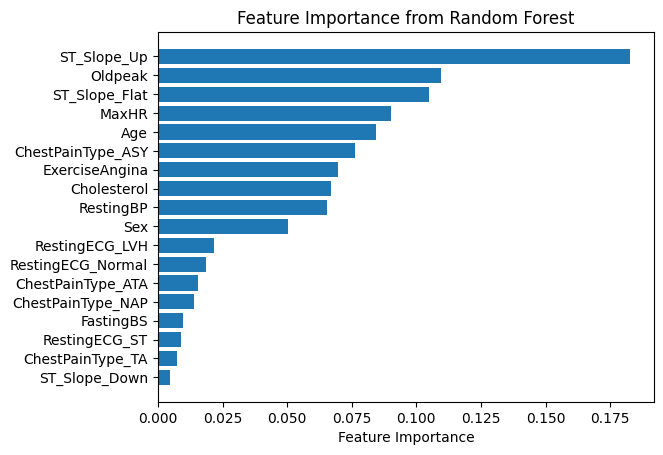

In [79]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance
feature_importance = rf_model.feature_importances_
features = pd.DataFrame({
    'Feature':  X_train.columns.tolist() ,  # Replace with actual feature names
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [80]:
# Set a threshold to select key features
important_features = features[features['Importance'] > 0.05]
print("Key Features:")
print(important_features)


Key Features:
              Feature  Importance
17        ST_Slope_Up    0.182812
7             Oldpeak    0.109567
16      ST_Slope_Flat    0.105008
5               MaxHR    0.090065
0                 Age    0.084283
8   ChestPainType_ASY    0.076232
6      ExerciseAngina    0.069536
3         Cholesterol    0.067076
2           RestingBP    0.065320
1                 Sex    0.050157


In [81]:
# Identify low-importance features
low_importance_features = features[features['Importance'] <= 0.01]['Feature']

# Drop low-importance features from the dataset
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)


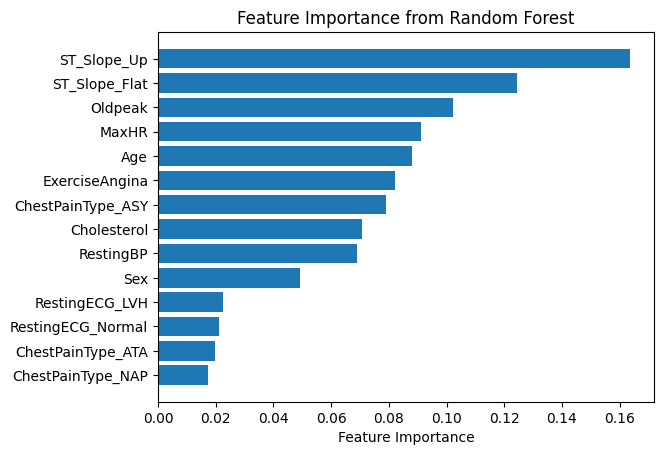

In [82]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_reduced, y_train)

# Extract feature importance
feature_importance = rf_model.feature_importances_
features = pd.DataFrame({
    'Feature':  X_train_reduced.columns.tolist() ,  # Replace with actual feature names
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


## Tuning Random Forest - Randomized Search

In [83]:
def tuning_random_forest(X_train, y_train, X_val, y_val, random_state=42):
  from sklearn.model_selection import RandomizedSearchCV
  from scipy.stats import randint

  # Define the model
  rf = RandomForestClassifier(random_state=42)

  # Define parameter distributions
  param_dist = {
      'n_estimators': randint(10, 1000),
      'max_depth': [None, 10, 20, 30],
      'min_samples_split': randint(2, 10),
      'min_samples_leaf': randint(1, 5),
      'max_features': ['sqrt', 'log2']
  }

  # Perform RandomizedSearch
  random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1', verbose=2, n_jobs=-1, random_state=42)
  random_search.fit(X_train, y_train)

  # Best parameters
  print("Best Parameters:", random_search.best_params_)


## Tuning GradientBoostingClassifier

In [84]:
def tuning_gradient_boosting(X_train, y_train, X_val, y_val, random_state=42):
  from sklearn.ensemble import GradientBoostingClassifier
  from sklearn.model_selection import RandomizedSearchCV
  from scipy.stats import uniform, randint

  # Define parameter distributions
  param_dist = {
      'n_estimators': randint(50, 500),
      'learning_rate': uniform(0.01, 0.2),
      'max_depth': randint(2, 10),
      'min_samples_split': randint(2, 10),
      'min_samples_leaf': randint(1, 5),
      'subsample': uniform(0.5, 0.5),
      'max_features': ['sqrt', 'log2']
  }
  # RandomizedSearchCV
  random_search = RandomizedSearchCV(
      estimator=GradientBoostingClassifier(random_state=42),
      param_distributions=param_dist,
      n_iter=50,
      scoring='f1',
      cv=5,
      verbose=2,
      n_jobs=-1,
      random_state=42
  )

  random_search.fit(X_train, y_train)

  # Best parameters
  print("Best Parameters:", random_search.best_params_)


## Tuning KNN

In [85]:
def tuning_knn(X_train, y_train, X_val, y_val, random_state=42):
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.model_selection import RandomizedSearchCV
  from scipy.stats import randint

  # Define parameter distributions
  param_dist = {
      'n_neighbors': randint(3, 30),
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan', 'minkowski'],
      'p': [1, 2]
  }

  # Initialize RandomizedSearchCV
  random_search = RandomizedSearchCV(
      estimator=KNeighborsClassifier(),
      param_distributions=param_dist,
      n_iter=50,  # Number of random combinations to try
      scoring='roc_auc',
      cv=5,  # 5-fold cross-validation
      verbose=2,
      n_jobs=-1,
      random_state=42
  )

  # Fit the model
  random_search.fit(X_train, y_train)

  # Best parameters
  print("Best Parameters:", random_search.best_params_)


##Tuning XGBoost

In [86]:
def tuning_xgboost(X_train, y_train, X_val, y_val, random_state=42):
  from sklearn.model_selection import RandomizedSearchCV
  from scipy.stats import uniform, randint
  import xgboost as xgb

  # Define parameter distributions
  param_dist = {
      'max_depth': randint(3, 10),                 # Depth of each tree
      'learning_rate': uniform(0.01, 0.3),        # Learning rate (eta)
      'n_estimators': randint(100, 500),          # Number of trees
      'subsample': uniform(0.5, 0.5),             # Row subsampling ratio [0.5, 1.0]
      'colsample_bytree': uniform(0.5, 0.5),      # Feature subsampling ratio [0.5, 1.0]
      'min_child_weight': randint(1, 10),         # Minimum child weight
      'gamma': uniform(0, 5),                     # Minimum loss reduction to make a split
      'reg_alpha': uniform(0, 10),                # L1 regularization
      'reg_lambda': uniform(1, 10)                # L2 regularization
  }

  # Initialize XGBoost classifier
  xgb_model = xgb.XGBClassifier(
      objective='binary:logistic',
      random_state=42,

      eval_metric='auc'
  )

  # Perform Randomized Search
  random_search = RandomizedSearchCV(
      estimator=xgb_model,
      param_distributions=param_dist,
      n_iter=50,                   # Number of random combinations to try
      scoring='roc_auc',           # Optimize for ROC-AUC
      cv=5,                        # 5-fold cross-validation
      verbose=2,
      n_jobs=-1,                   # Use all processors
      random_state=42
  )

  # Fit RandomizedSearchCV
  random_search.fit(X_train, y_train)

  # Best parameters and best score
  print("Best Parameters:", random_search.best_params_)
  print("Best ROC-AUC Score:", random_search.best_score_)


## Deep Learning with CNN Classification

In [87]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import tensorflow as tf
from tensorflow import keras
X_train = tf.constant(X_train)
y_train = tf.constant(y_train)
X_test = tf.constant(X_test)
y_test = tf.constant(y_test)
model = tf.keras.Sequential([tf.keras.layers.Dense(128, activation="elu"),
                  tf.keras.layers.Dense(256, activation="elu"),
                  tf.keras.layers.Dense(128, activation="elu"),
                  tf.keras.layers.Dense(1, activation="sigmoid")
 ])
# Compile the model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
# Fit the model
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), verbose=0)
#model.evaluate(X_test, y_test)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8509 - loss: 0.3465 
Test accuracy: 0.8859060406684875


In [88]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate precision, recall, and F1-score
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Precision: 0.8717948717948718
Recall: 0.9066666666666666
F1-Score: 0.8888888888888888


Hungarian: [Hungarian source ](https://archive.ics.uci.edu/dataset/45/heart+disease)
